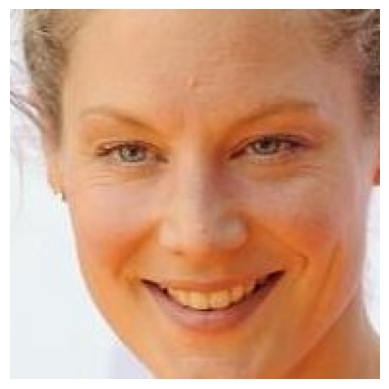

In [3]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

def detect_faces_in_nested_folders(input_folder, output_folder=None):
    if output_folder and not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
    )
    
    results = {}

    for subfolder in os.listdir(input_folder):
        subfolder_path = os.path.join(input_folder, subfolder)
        if os.path.isdir(subfolder_path):
            if output_folder:
                sub_output_folder = os.path.join(output_folder, subfolder)
                if not os.path.exists(sub_output_folder):
                    os.makedirs(sub_output_folder)

            for filename in os.listdir(subfolder_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    try:
                        image_path = os.path.join(subfolder_path, filename)
                        image = cv2.imread(image_path)
                        if image is None:
                            print(f"Không thể đọc ảnh: {image_path}")
                            continue
                        
                        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        faces = face_cascade.detectMultiScale(
                            gray,
                            scaleFactor=1.1,
                            minNeighbors=5,
                            minSize=(30, 30)
                        )

                        result_key = f"{subfolder}/{filename}"
                        results[result_key] = len(faces)
                        
                        # Lưu từng khuôn mặt được cắt
                        for i, (x, y, w, h) in enumerate(faces):
                            face_crop = image[y:y+h, x:x+w]
                            if output_folder:
                                face_filename = f"face_{i}_result_{filename}"
                                output_path = os.path.join(sub_output_folder, face_filename)
                                cv2.imwrite(output_path, face_crop)
                    
                    except Exception as e:
                        print(f"Lỗi khi xử lý {filename} trong {subfolder}: {str(e)}")
    
    return results

# Gọi thử hàm
try:
    input_folder = '/kaggle/working/combined_dataset'
    output_folder = '/kaggle/working/Faces_detected'
    
    face_detection_results = detect_faces_in_nested_folders(input_folder, output_folder)
    
    # Hiển thị một khuôn mặt cắt ví dụ
    example_face = None
    for subfolder in os.listdir(output_folder):
        sub_output_folder = os.path.join(output_folder, subfolder)
        if os.path.isdir(sub_output_folder):
            for filename in os.listdir(sub_output_folder):
                if filename.startswith('face_'):
                    example_face = cv2.imread(os.path.join(sub_output_folder, filename))
                    break
        if example_face is not None:
            break
    
    if example_face is not None:
        plt.imshow(cv2.cvtColor(example_face, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

except Exception as e:
    print(f"Lỗi: {str(e)}")


In [4]:
import os
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18 as torchvision_resnet18, ResNet18_Weights

# ============================
# Dataset for Triplet
# ============================
class TripletFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.people = os.listdir(root_dir)
        self.image_paths = {p: os.listdir(os.path.join(root_dir, p)) for p in self.people}

    def __len__(self):
        return 10000

    def __getitem__(self, idx):
        person = random.choice(self.people)
        img_paths = random.sample(self.image_paths[person], 2)
        anchor_path = os.path.join(self.root_dir, person, img_paths[0])
        positive_path = os.path.join(self.root_dir, person, img_paths[1])

        negative_person = random.choice(self.people)
        while negative_person == person:
            negative_person = random.choice(self.people)
        negative_path = os.path.join(self.root_dir, negative_person, random.choice(self.image_paths[negative_person]))

        anchor = Image.open(anchor_path).convert("RGB")
        positive = Image.open(positive_path).convert("RGB")
        negative = Image.open(negative_path).convert("RGB")

        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative

# ============================
# Custom BasicBlock
# ============================
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

# ============================
# Custom ResNet18
# ============================
class CustomResNet18(nn.Module):
    def __init__(self, num_classes=128):
        super(CustomResNet18, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(BasicBlock, 64, 2)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return F.normalize(x, p=2, dim=1)

# ============================
# Load pretrained weights
# ============================
def load_pretrained_weights(custom_model, pretrained_model):
    pretrained_dict = pretrained_model.state_dict()
    custom_dict = custom_model.state_dict()
    matched_dict = {k: v for k, v in pretrained_dict.items()
                    if k in custom_dict and v.size() == custom_dict[k].size()}
    custom_dict.update(matched_dict)
    custom_model.load_state_dict(custom_dict)
    print(f"✅ Loaded {len(matched_dict)} pretrained weights.")

# ============================
# Triplet Network
# ============================
class TripletNetwork(nn.Module):
    def __init__(self):
        super(TripletNetwork, self).__init__()
        self.embedding = CustomResNet18()
        pretrained_resnet = torchvision_resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        load_pretrained_weights(self.embedding, pretrained_resnet)

    def forward(self, x):
        return self.embedding(x)

# ============================
# Triplet Loss
# ============================
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive, p=2)
        neg_dist = F.pairwise_distance(anchor, negative, p=2)
        loss = F.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()

# ============================
# Accuracy (positive closer than negative)
# ============================
def compute_accuracy(anchor, positive, negative):
    pos_dist = F.pairwise_distance(anchor, positive, p=2)
    neg_dist = F.pairwise_distance(anchor, negative, p=2)
    correct = (pos_dist < neg_dist).sum().item()
    total = anchor.size(0)
    return correct / total

# ============================
# Evaluation
# ============================
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for anchor, positive, negative in dataloader:
            anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()
            anchor_emb = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            acc = compute_accuracy(anchor_emb, positive_emb, negative_emb)

            batch_size = anchor.size(0)
            total_loss += loss.item() * batch_size
            total_correct += acc * batch_size
            total_samples += batch_size

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc

# ============================
# Training
# ============================
def main():
    train_dir = '/kaggle/working/Faces_detected'
    test_dir  = '/kaggle/input/vggface2/val'

    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    train_dataset = TripletFaceDataset(train_dir, transform_train)
    test_dataset  = TripletFaceDataset(test_dir, transform_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = TripletNetwork().cuda()
    criterion = TripletLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    for epoch in range(1, 101):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total_samples = 0
        for anchor, positive, negative in train_loader:
            anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()
            anchor_emb = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            acc = compute_accuracy(anchor_emb, positive_emb, negative_emb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_size = anchor.size(0)
            running_loss += loss.item() * batch_size
            running_correct += acc * batch_size
            total_samples += batch_size

        train_loss = running_loss / total_samples
        train_acc = running_correct / total_samples

        test_loss, test_acc = evaluate(model, test_loader, criterion)

        print(f"✅ Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    # Sau khi train xong hết 100 epochs, mới lưu model
    torch.save(model.state_dict(), "/kaggle/working/final_triplet_resnet18_ss2.pth")
    print(f"💾 Saved final model after training.")

if __name__ == '__main__':
    main()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]


✅ Loaded 120 pretrained weights.
✅ Epoch 01 | Train Loss: 0.6090 | Train Acc: 0.7706 | Test Loss: 0.6438 | Test Acc: 0.7609
✅ Epoch 02 | Train Loss: 0.4772 | Train Acc: 0.8249 | Test Loss: 0.5614 | Test Acc: 0.7798
✅ Epoch 03 | Train Loss: 0.4372 | Train Acc: 0.8457 | Test Loss: 0.6510 | Test Acc: 0.7494
✅ Epoch 04 | Train Loss: 0.4244 | Train Acc: 0.8516 | Test Loss: 0.6144 | Test Acc: 0.7669
✅ Epoch 05 | Train Loss: 0.4059 | Train Acc: 0.8616 | Test Loss: 0.5709 | Test Acc: 0.7875
✅ Epoch 06 | Train Loss: 0.3928 | Train Acc: 0.8677 | Test Loss: 0.6035 | Test Acc: 0.7764
✅ Epoch 07 | Train Loss: 0.3900 | Train Acc: 0.8683 | Test Loss: 0.5447 | Test Acc: 0.7954
✅ Epoch 08 | Train Loss: 0.3905 | Train Acc: 0.8649 | Test Loss: 0.5587 | Test Acc: 0.7964
✅ Epoch 09 | Train Loss: 0.3769 | Train Acc: 0.8741 | Test Loss: 0.6196 | Test Acc: 0.7622
✅ Epoch 10 | Train Loss: 0.3775 | Train Acc: 0.8732 | Test Loss: 0.6239 | Test Acc: 0.7637
✅ Epoch 11 | Train Loss: 0.3697 | Train Acc: 0.8799 | Tes